> * #### THIS POST SHOULD NOT USE LAMBDA ENVIRONMENT - INSTEAD IT SHOULD BE PURE VOILA DEPLOYMENT.  USE THE 'volgpt-post-temp' setup for the actual post too, BUT CREATE A NEW FOLDER ON HOME AND ARTIFACT REPO CALLED 'volgpt-post'.  Keep volgpt-post-temp (i.e., don't delete it, because it will be useful as a template in future)
> * #### NANOGPT POST SHOWS THE IMPLEMENTATION, NO NEED TO DO THAT AGAIN.  IN THIS POST, JUST FOCUS ON RESULTS

> Create a visualization for the vol predictor
>> * __[See Karpathy's ConvNetJS demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html)__
>> * __[See tensorflow Neural Network Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.17803&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)__
>> * provide ability in post to select a range of of tick data from a held out sample and obtain a vol prediction for it
>> * show the mz regressions for the prediction
>> * see if ChatGPT can suggest how to do this

> * WHAT DO I DO ABOUT THE SPARSE NATURE OF THE DATASET?

> * MANY OF THE COLUMNS ARE NULL/NAN/ZERO?  
>> WHAT COLUMNS, IF ANY, DO I DROP?

> * WHAT USE TO I MAKE OF 'UNK'

> * what to do about NANs and NULLs?  Set to 'UNK'?  
>> From ChatGPT: "In Transformers, "UNK" is a special token that represents an out-of-vocabulary (OOV) word, meaning a word that is not present in the vocabulary used by the language model. When a word is encountered during tokenization that is not present in the vocabulary, it is replaced with the UNK token." <br>

> * what to do about zero values?
>> From ChatGPT: "Sparse datasets can make training a transformer more difficult, especially if the dataset contains predominantly zero values. This is because the sparsity can lead to computational inefficiencies and difficulties in training the model effectively. <br> <br>
>> In natural language processing tasks, for example, the input data is often encoded as sparse matrices of one-hot vectors, which can be very large and memory-intensive. If the input data is extremely sparse, it can be difficult for the model to effectively learn from the data and make accurate predictions. <br> <br>
>> To address these issues, various techniques have been developed to handle sparse data in transformers, such as embedding techniques that allow the model to learn more efficiently from sparse input data, and compression techniques that reduce the memory footprint of the input data." <br>

> * Using NanoGPT (i.e., a transformer or LLM - WHICH IS IT EXACTLY??), I don't need to treat things like raw returns and log returns separately.  I just throw them all in together. <br>
>> But! Does this help? Is the vol forecast better as a result?
***

> **This notebook contains workings only**
***

#### Import and prepare high-frequency tick data for AAPL and JPM

In [1]:
# check GPU (if working on local machine)
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"device: {device}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

device: cuda
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
# for running in docker image
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from volgpt_data import high_frequency_data
df_data, prop_missing_pct, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, AAPL_stats, JPM_stats = high_frequency_data()

print(df_data.shape, AAPL_rr.shape, JPM_rr.shape, AAPL_lr.shape, JPM_lr.shape)

(1070871, 64) (444470,) (332093,) (444448,) (332089,)


#### Descriptive statistics

In [4]:
# Descriptive statistics
from scipy import stats

print("Descriptive statistics for AAPL: ","\n"
      "Number of observations = ",AAPL_stats.nobs,"\n"
      "Minimum, Maximum = ", str(AAPL_stats.minmax),"\n"
      "Mean = %.5f" %  AAPL_stats.mean,"\n"
      "Variance = %.5f" %  AAPL_stats.variance,"\n"
      "Standard deviation = %.5f" %  AAPL_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  AAPL_stats.skewness,"\n"
      "Kurtosis = %.5f" %  AAPL_stats.kurtosis,"\n") 

print("Descriptive statistics for JPM: ","\n"
      "Number of observations = ",JPM_stats.nobs,"\n"
      "Minimum, Maximum = ", str(JPM_stats.minmax),"\n"
      "Mean = %.5f" %  JPM_stats.mean,"\n"
      "Variance = %.5f" %  JPM_stats.variance,"\n"
      "Standard deviation = %.5f" %  JPM_stats.variance**0.5,"\n"
      "Skewness = %.5f" %  JPM_stats.skewness,"\n"
      "Kurtosis = %.5f" %  JPM_stats.kurtosis)

Descriptive statistics for AAPL:  
Number of observations =  444470 
Minimum, Maximum =  (-152.83124999999998, 165.5690434782609) 
Mean = -0.00017 
Variance = 4.54474 
Standard deviation = 2.13184 
Skewness = 1.33822 
Kurtosis = 2684.83480 

Descriptive statistics for JPM:  
Number of observations =  332093 
Minimum, Maximum =  (-39.10681818181817, 50.888157894736835) 
Mean = -0.00007 
Variance = 0.38692 
Standard deviation = 0.62203 
Skewness = -1.59559 
Kurtosis = 1684.46534


#### Proportion of missing values and zero values for each column

In [5]:
# Proportion of missing values and zero values for each column

print(prop_missing_pct)

Ticker                          0.0000%
OpenBarTime                     0.0000%
OpenBidPrice                    0.1044%
OpenBidSize                     0.1044%
OpenAskPrice                    0.1044%
OpenAskSize                     0.1044%
FirstTradeTime                 32.1911%
FirstTradePrice                32.1911%
FirstTradeSize                 32.1911%
HighBidTime                     0.0001%
HighBidPrice                    0.0001%
HighBidSize                     0.0028%
HighAskTime                     0.0001%
HighAskPrice                    0.0001%
HighAskSize                     0.0181%
HighTradeTime                  32.1911%
HighTradePrice                 32.1911%
HighTradeSize                  32.1911%
LowBidTime                      0.0001%
LowBidPrice                     0.0001%
LowBidSize                      0.0344%
LowAskTime                      0.0001%
LowAskPrice                     0.0001%
LowAskSize                      0.0008%
LowTradeTime                   32.1911%


#### Plot raw returns and log returns

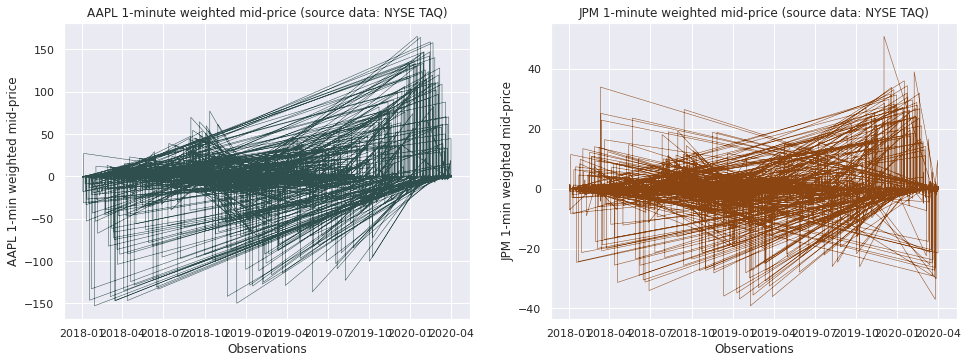

In [6]:
# Returns plots
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns   
sns.set()

startEndTimes = ['2018-01-01 00:00:00.0', '2020-03-31 23:59:59.0']
startTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[0])
endTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[1])
startDate = str(startTime.date()).replace('-','.')
endDate = str(endTime.date()).replace('-','.')
currentTime = str(date.today())

fig = plt.figure(figsize=(16,12))  

ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(AAPL_rr, color='darkslategrey', linewidth=0.5)

ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(JPM_rr, color='saddlebrown', linewidth=0.5)

plt.show();

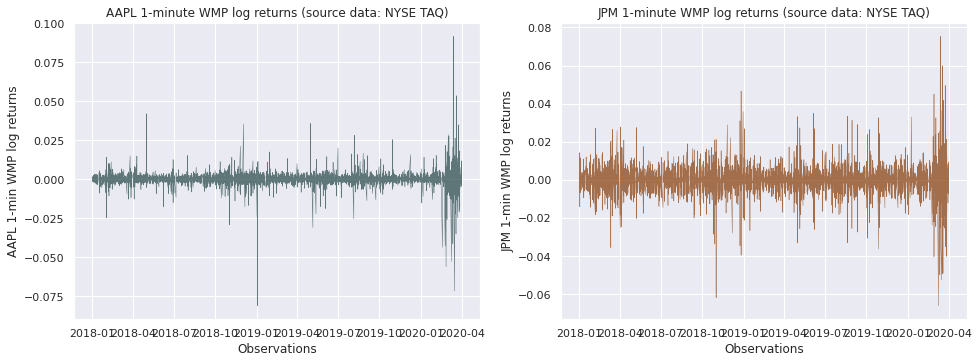

In [7]:
# Log returns plots
from scipy import stats
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(16,12)) 

ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(AAPL_lr, color='darkslategrey', linewidth=0.5, alpha=0.75)

ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(JPM_lr, color='saddlebrown', linewidth=0.5, alpha=0.75)

plt.show();

#### Create text file for input to NanoGPT

In [8]:
# save df_data as a text file
df_data.to_csv('df_data.txt', sep='\t', index=False)

#### From ChatGPT re structure of text file:

> "In this example, we first create a sample dataframe called df. We then use the to_csv method to save the dataframe to a file called data.txt. The sep parameter specifies the delimiter to use in the text file (in this case, a tab character), and the index parameter is set to False to exclude the index from the output.  You can customize the parameters of to_csv method as per your requirements."

#### My next prompt: 

> I shall use data.txt as an input to a large language model (Karpathy's NanoGPT).  Should I include the sep='/t' parameter?

#### ChatGPT:

> "Yes, you should include the sep='\t' parameter in the to_csv method to specify the delimiter as a tab character. <br> <br>
> If the input file for Karpathy's NanoGPT expects tab-separated values, you need to ensure that the file you're providing is also in the same format. In the example I provided earlier, the sep='\t' parameter specifies that the data will be saved as tab-separated values. <br> <br>
> Therefore, including this parameter will ensure that the saved text file has a tab-separated format, which is the expected format for input to Karpathy's NanoGPT."

In [9]:
# Check that the text file was saved correctly

df_exported = pd.read_csv('df_data.txt', sep='\t') # read the text file into a dataframe

print('shape of df_data: ', df_data.shape)
print('shape of df_exported: ', df_exported.shape)

shape of df_data:  (1070871, 64)
shape of df_exported:  (1070871, 64)


# Load data into NanoGPT

#### __[See nanogpt/nanogpt.ipynb commit v0.1.18 for consolidated code](https://github.com/johncollinsai/nanogpt/blob/bc54688a22dbce92648ad36fec865140ab1d6544/nanogpt.ipynb)__

In [10]:
# See nanogpt/nanogpt.ipynb commit v0.1.18 for consolidated code
# https://github.com/johncollinsai/nanogpt/blob/bc54688a22dbce92648ad36fec865140ab1d6544/nanogpt.ipynb

import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(3407)

# get data
with open('df_data.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.208568 M parameters
step 0: train loss 4.1594, val loss 4.1624
step 100: train loss 2.2012, val loss 2.2861
step 200: train loss 2.0010, val loss 2.1111
step 300: train loss 1.8599, val loss 1.9553
step 400: train loss 1.7501, val loss 1.8505
step 500: train loss 1.6329, val loss 1.7861
step 600: train loss 1.5878, val loss 1.7392
step 700: train loss 1.5455, val loss 1.6815
step 800: train loss 1.5128, val loss 1.6665
step 900: train loss 1.5159, val loss 1.6657
step 1000: train loss 1.4989, val loss 1.6351
step 1100: train loss 1.4864, val loss 1.6390
step 1200: train loss 1.4815, val loss 1.6365
step 1300: train loss 1.4500, val loss 1.6015
step 1400: train loss 1.4570, val loss 1.6249
step 1500: train loss 1.4545, val loss 1.6139
step 1600: train loss 1.4332, val loss 1.6081
step 1700: train loss 1.4369, val loss 1.6101
step 1800: train loss 1.4315, val loss 1.5975
step 1900: train loss 1.4441, val loss 1.6149
step 2000: train loss 1.4351, val loss 1.6004
step 2100: train loss 1.

#### Generate tick data

The decode() function is used to convert the output produced by m.generate() from the list of token IDs to a human-readable string. The output of m.generate() is a tensor of long integers, which is converted to a Python list with .tolist(). Then, the resulting list is passed as an argument to decode(), which uses volGPT's trained bigram language model to convert the token IDs to the corresponding text representations. Finally, the output of decode() is assigned to the variable pred.

In [15]:
# generate 10k tokens from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
pred = decode(m.generate(context, max_new_tokens=10000)[0].tolist())
print(pred)

	14:17:00.508195082	253.96	100	19:49:59.985735330	176.54	1.0	12:06:43.073887675	189.34	1.0	0.01	0.01		17	108.55277	11857	12910	18587	4801	2187	78	3001	14440	173	9035	0	-0.62318	-0.33483	108.52485	193.84127	167.33731	0.0363333333333333333		-0.00015148329536989-05
JPM	08:18:00.000000000	136.4	100.0	110.97	100.0				04:42:00.000000000	119.25	100	16:19:00.922935437	177.71	1000	19:30:43.406429200	113.03	30.0	11:03:51.783925243	202.3472	176.75	-0.023227249137976288	0.000154950255615894575	-0.000130317608016055967
JPM	16:50:00.000000000	114.88	300.0	186.25	200.0	19:53:39.983376662	195.92	9z0.0	11:24:00.329442785	214.9	697.0	18:21:24.978095492	289.85	80.0	15:56:38.184777606	187.99	800.0	19:05:59.290663486	188.58	100.0	10:31:56.839297891	137.75	100	09:42:12.869513922	105.85	100	13:51:62.453825389	170.03	54.0	17:57:29.148013997	193.06	200	13:00:34.437360000	116.58	14.0	15:06:59.854981600	244.11	100.0	10:22:35.390277153	247.27	21.0	04:55:39.732298625	260.9	900.0	12:46:37.722050499	199.7387	100.0	1

> The decode() function is used to convert the output produced by m.generate() from the list of token IDs to a human-readable string. The output of m.generate() is a tensor of long integers, which is converted to a Python list with .tolist(). Then, the resulting list is passed as an argument to decode(), which uses volGPT's trained bigram language model to convert the token IDs to the corresponding text representations. Finally, the output of decode() is assigned to the variable pred.

# QUESTION: DO I WANT A NUMPY ARRAY OR A DATAFRAME TO COMPUTE THE MZ REGRESSIONS?

Ask ChatGPT > see "DL Model Predictions" chat

In [ ]:
# IT MIGHT BE HELPFUL TO ASSIGN COLUMN HEADINGS SO THAT I KNOW WHAT COLUMN IS WHAT > OR USE A PYTHON DICTIONARY TO MAP COLUMN HEADINGS TO COLUMN NUMBERS?

# Set column headings
df_data.columns = ["Date","Ticker","TimeBarStart","OpenBarTime","OpenBidPrice","OpenBidSize", "OpenAskPrice","OpenAskSize","FirstTradeTime","FirstTradePrice","FirstTradeSize","HighBidTime","HighBidPrice","HighBidSize","HighAskTime","HighAskPrice","HighAskSize","HighTradeTime","HighTradePrice","HighTradeSize","LowBidTime","LowBidPrice","LowBidSize","LowAskTime","LowAskPrice","LowAskSize","LowTradeTime","LowTradePrice","LowTradeSize","CloseBarTime","CloseBidPrice","CloseBidSize","CloseAskPrice","CloseAskSize","LastTradeTime","LastTradePrice","LastTradeSize","MinSpread","MaxSpread","CancelSize","VolumeWeightPrice","NBBOQuoteCount","TradeAtBid","TradeAtBidMid","TradeAtMid","TradeAtMidAsk","TradeAtAsk","TradeAtCrossOrLocked","Volume","TotalTrades","FinraVolume","FinraVolumeWeightPrice","UptickVolume","DowntickVolume","RepeatUptickVolume","RepeatDowntickVolume","UnknownTickVolume","TradeToMidVolWeight","TradeToMidVolWeightRelative","TimeWeightBid","TimeWeightAsk"]

# Set a date-time index, using OpenBarTime
df_data['DateTimeIndex'] = pd.to_datetime(df_data['Date'].astype(str)) + pd.to_timedelta(df_data['OpenBarTime'].astype(str))
df_data = df_data.set_index('DateTimeIndex')
df_data = df_data.drop(['Date','TimeBarStart'], axis=1) # Drop original Date and TimeBarStart columns

df_data.head().T

# NEXT STEPS | MONDAY

> * Do I need the column headings to show in the output?

> * How do I identify the raw returns and log returns?

> * Make sure predictions are based on the validation dataset

> * Compute MZ regressions

# Evaluate the model

#### MZ Regressions

***
# End

***
# Original code for volgpt_data.py

# Prepare data

In [ ]:
import os
import glob
import pandas as pd
import numpy as np

# import HF data (AAPL, JPM), being 563 daily files
path = 'allfiles'
all_files = glob.glob(os.path.join(path,"**/*.csv.gz"))

np_array_list = []
for file_ in all_files:
    df = pd.read_csv(file_,index_col=None, header=0) # read the csv's
    np_array_list.append(df.values) # convert to numpy array

comb_np_array = np.vstack(np_array_list) # Create bit array
df_data = pd.DataFrame(comb_np_array) # Create dataframe

print(df_data.shape)

In [ ]:
# Set column headings
df_data.columns = ["Date","Ticker","TimeBarStart","OpenBarTime","OpenBidPrice","OpenBidSize", "OpenAskPrice","OpenAskSize","FirstTradeTime","FirstTradePrice","FirstTradeSize","HighBidTime","HighBidPrice","HighBidSize","HighAskTime","HighAskPrice","HighAskSize","HighTradeTime","HighTradePrice","HighTradeSize","LowBidTime","LowBidPrice","LowBidSize","LowAskTime","LowAskPrice","LowAskSize","LowTradeTime","LowTradePrice","LowTradeSize","CloseBarTime","CloseBidPrice","CloseBidSize","CloseAskPrice","CloseAskSize","LastTradeTime","LastTradePrice","LastTradeSize","MinSpread","MaxSpread","CancelSize","VolumeWeightPrice","NBBOQuoteCount","TradeAtBid","TradeAtBidMid","TradeAtMid","TradeAtMidAsk","TradeAtAsk","TradeAtCrossOrLocked","Volume","TotalTrades","FinraVolume","FinraVolumeWeightPrice","UptickVolume","DowntickVolume","RepeatUptickVolume","RepeatDowntickVolume","UnknownTickVolume","TradeToMidVolWeight","TradeToMidVolWeightRelative","TimeWeightBid","TimeWeightAsk"]

# Set a date-time index, using OpenBarTime
df_data['DateTimeIndex'] = pd.to_datetime(df_data['Date'].astype(str)) + pd.to_timedelta(df_data['OpenBarTime'].astype(str))
df_data = df_data.set_index('DateTimeIndex')
df_data = df_data.drop(['Date','TimeBarStart'], axis=1) # Drop original Date and TimeBarStart columns

df_data.head().T

In [ ]:
# Calculate the proportion of missing values and zero values for each column
prop_missing = (df_data.isna().sum() + (df_data == 0).sum()) / len(df_data)
prop_missing_pct = prop_missing.map('{:.4%}'.format)  # Format as a percentage to 4dp

print(prop_missing_pct)

In [ ]:
# Set datatypes for columns used to compute weighted mid-price
df_data['CloseBidSize'] = df_data['CloseBidSize'].astype(float)
df_data['CloseAskSize'] = df_data['CloseAskSize'].astype(float)
df_data['CloseBidPrice'] = df_data['CloseBidPrice'].astype(float)
df_data['CloseAskPrice'] = df_data['CloseAskPrice'].astype(float)

# Compute WeightedMidPrice using the closing prices per analysis in my high-frequency-data post
df_data['WeightedMidPrice'] = ((df_data['CloseBidSize']*df_data['CloseAskPrice']) + (df_data['CloseAskSize']*df_data['CloseBidPrice'])) / (df_data['CloseBidSize'] + df_data['CloseAskSize'])

# print(df_data.dtypes.to_string(max_rows=None))

#### Compute raw returns and log returns

In [ ]:
# Calculate AAPL_rr
AAPL_rr = df_data.loc[df_data['Ticker'] == "AAPL"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()

# Calculate JPM_rr
JPM_rr = df_data.loc[df_data['Ticker'] == "JPM"]
JPM_rr = JPM_rr['WeightedMidPrice'] - JPM_rr['WeightedMidPrice'].shift(1)
JPM_rr = JPM_rr[JPM_rr.notna()].copy()
JPM_rr = JPM_rr[JPM_rr != 0].copy()

# Merge AAPL_rr and JPM_rr with df_data
df_data = df_data.merge(AAPL_rr.to_frame(name='AAPL_rr'), left_index=True, right_index=True, how='left')
df_data = df_data.merge(JPM_rr.to_frame(name='JPM_rr'), left_index=True, right_index=True, how='left')

# Log returns
AAPL_lr = df_data.loc[df_data['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = df_data.loc[df_data['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()

# Append log returns as additional columns to df_data
df_data = pd.concat([df_data, AAPL_lr.rename('AAPL_lr'), JPM_lr.rename('JPM_lr')], axis=1)

print(df_data.shape)
# df_data[['AAPL_rr', 'JPM_rr', 'AAPL_lr', 'JPM_lr']].head(5).T

***
> #### WHY ARE THE TWO SETS OF DESCRIPTIVE STATS THAT FOLLOW DIFFERENT?

In [ ]:
# Describe the data
df_data[['AAPL_rr', 'JPM_rr', 'AAPL_lr', 'JPM_lr']].describe().T

In [ ]:
# Descriptive statistics
from scipy import stats

# Calculate AAPL_rr and remove nan and 0 values
AAPL_rr = df_data.loc[df_data['Ticker'] == "AAPL"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()

# Calculate JPM_rr and remove nan and 0 values
JPM_rr = df_data.loc[df_data['Ticker'] == "JPM"]
JPM_rr = JPM_rr['WeightedMidPrice'] - JPM_rr['WeightedMidPrice'].shift(1)
JPM_rr = JPM_rr[JPM_rr.notna()].copy()
JPM_rr = JPM_rr[JPM_rr != 0].copy()

j = stats.describe(AAPL_rr)
print("Descriptive statistics for AAPL: ","\n"
      "Number of observations = ",j.nobs,"\n"
      "Minimum, Maximum = ", str(j.minmax),"\n"
      "Mean = %.5f" %  j.mean,"\n"
      "Variance = %.5f" %  j.variance,"\n"
      "Standard deviation = %.5f" %  j.variance**0.5,"\n"
      "Skewness = %.5f" %  j.skewness,"\n"
      "Kurtosis = %.5f" %  j.kurtosis) 

k = stats.describe(JPM_rr)
print("Descriptive statistics for JPM: ","\n"
      "Number of observations = ",k.nobs,"\n"
      "Minimum, Maximum = ", str(k.minmax),"\n"
      "Mean = %.5f" %  k.mean,"\n"
      "Variance = %.5f" %  k.variance,"\n"
      "Standard deviation = %.5f" %  k.variance**0.5,"\n"
      "Skewness = %.5f" %  k.skewness,"\n"
      "Kurtosis = %.5f" %  k.kurtosis)

In [ ]:
# IMPORTANT: Remove outliers?? OR NOT???
'''
# Remove outliers
Q1l = AAPL_lr.quantile(0.001)   
Q3l = AAPL_lr.quantile(0.999)   
IQl = Q3l - Q1l
Q1r = AAPL_rr.quantile(0.001)   
Q3r = AAPL_rr.quantile(0.999)   
IQr = Q3r - Q1r
AAPL_lr = AAPL_lr[~((AAPL_lr < (Q1l - 1.5 * IQl)) | (AAPL_lr > (Q3l + 1.5 * IQl)))]
AAPL_rr = AAPL_rr[~((AAPL_rr < (Q1r - 1.5 * IQr)) | (AAPL_rr > (Q3r + 1.5 * IQr)))]
JPM_lr = JPM_lr[~((JPM_lr < (Q1l - 1.5 * IQl)) | (JPM_lr > (Q3l + 1.5 * IQl)))]
JPM_rr = JPM_rr[~((JPM_rr < (Q1r - 1.5 * IQr)) | (JPM_rr > (Q3r + 1.5 * IQr)))]
'''

> #### END | WHY ARE THE TWO SETS OF DESCRIPTIVE STATS ABOVE DIFFERENT?
***

#### Returns and log returns plots

In [ ]:
# Returns plots
from datetime import datetime, timedelta, date
from scipy import stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns   
sns.set()

startEndTimes = ['2018-01-01 00:00:00.0', '2020-03-31 23:59:59.0']
startTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[0])
endTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[1])
startDate = str(startTime.date()).replace('-','.')
endDate = str(endTime.date()).replace('-','.')
currentTime = str(date.today())

fig = plt.figure(figsize=(16,12))  

j = df_data.loc[df_data['Ticker'] == "AAPL"]
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(j, color='darkslategrey', linewidth=0.5)

j = df_data.loc[df_data['Ticker'] == "JPM"]
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(j, color='saddlebrown', linewidth=0.5)

plt.show();

In [ ]:
# Log returns plots
from scipy import stats
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(16,12))  

# Log returns (NB: shown without removal of outliers)
AAPL_lr = df_data.loc[df_data['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = df_data.loc[df_data['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()

j = np.array(AAPL_lr).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(j, color='darkslategrey', linewidth=0.5, alpha=0.75)

j = np.array(JPM_lr).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(j, color='saddlebrown', linewidth=0.5, alpha=0.75)

plt.show();